# Lecture 13

October 21, 2024

I lectured for a while on Least Squares, and its relationship to orthogonal projection. Here are some related problems.

**References:**

* Sergei Treil's *[Linear Algebra Done Wrong](https://www.math.brown.edu/streil/papers/LADW/LADW.html),* Chapter 5. (This is a freely available linear algebra book.)
* Computational mathematics with SageMath has discussions of Least Squares in Sections 2.4 and Chapter 13 (more technical).

## Problem 1

Consider a polygonal loop in $\mathbb R^2$ given as a list of `vertices` $[v_0, v_1, \ldots, v_n=v_0]$ together with an increasing sequence of `times` $[t_0=0, t_1, \ldots, t_n]$. From this information, we can define a path 
$$\gamma:[0, t_n] \to \mathbb R^2$$
as a concatenation of (affine) linear parameterizations of line segments $[t_i, t_{i+1}] \to \overline{v_i, v_{i+1}}.$

By rescaling time, we may assume that $t_n=2 \pi$. A *finite Fourier series of period $2\pi$* is a sum of the form
$$a_0 + \sum_{n=1}^N \left[a_n \cos(nx) + b_n \sin(nx)\right].$$
We'll call $N$ the *frequency bound*. Given a positive integer `frequency_bound` and the data above, compute the best approximation to $\gamma$ by a pair of function $\phi(t) = \big(x(t), y(t)\big)$ where both $x(t)$ and $y(t)$ are finite Fourier series of period $2\pi$ with frequency bound `frequency_bound`. Here *best* should be intepretted as minimizing the square integral
$$\int_0^{2\pi} \big\|\gamma(t)-\phi(t)\big\|^2~dt,$$
where $\| \cdot \|$ denotes the Euclidean norm of a vector.

In [1]:
frequency_bound = 6
vertices = [(0, -2), (2, 1), (1, 2), (0, 3/4), (0, 3/4), (-1, 2), (-2, 1),(0, -2),(0, -2)]
times =    [      0,      1,      2,        3,        5,       6,       7,      8,      9]

In [2]:
def inner_product(f, g):
    return (f*g).integrate(t, 0, 2*pi)
def norm_squared(f):
    return inner_product(f, f)

In [3]:
def basis(frequency_bound):
    var('t')
    basis = [(1, 0), (0, 1)]
    for i in range(1, frequency_bound+1):
        basis.append((sin(i*t), 0))
        basis.append((cos(i*t), 0))
        basis.append((0, sin(i*t)))
        basis.append((0, cos(i*t)))
    return basis

In [4]:
basis_functions = matrix(SR, basis(frequency_bound))
show(basis_functions)

26 x 2 dense matrix over Symbolic Ring (use the '.str()' method to see the entries)

In [5]:
# Check that the basis is orthogonal:
for i in range(basis_functions.nrows()):
    for j in range(i+1, basis_functions.nrows()):
        assert inner_product(basis_functions[i], basis_functions[j]) == 0

In [6]:
norms_squared = [norm_squared(b) for b in basis_functions.rows()]
norms_squared

[2*pi,
 2*pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi,
 pi]

In [7]:
# Record the number of segments
nv = len(vertices)-1
nv

8

In [8]:
# Ensure vertices are vectors
vertices = [vector(v) for v in vertices]
vertices

[(0, -2),
 (2, 1),
 (1, 2),
 (0, 3/4),
 (0, 3/4),
 (-1, 2),
 (-2, 1),
 (0, -2),
 (0, -2)]

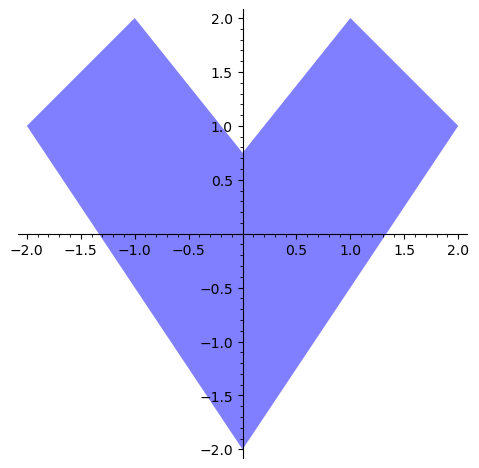

In [9]:
plt = polygon2d(vertices[:-1], alpha=0.5)
plt

In [10]:
if not times:
    # compute the total length
    length = sum([(vertices[i]-vertices[i+1]).norm() for i in range(nv)])
    traveled = RDF(0)
    times = [traveled]
    for i in range(nv):
        traveled += (vertices[i+1]-vertices[i]).norm()
        times.append(RDF(2*pi)*traveled/length)
else:
    #rescale times to be in the interval [0, 2*pi]
    times = [t*2*pi/times[-1] for t in times]
times

[0, 2/9*pi, 4/9*pi, 2/3*pi, 10/9*pi, 4/3*pi, 14/9*pi, 16/9*pi, 2*pi]

In [11]:
segments = []
for i in range(nv):
    a = times[i]
    b = times[i+1]
    seg(t) = (1/(b-a) * ((b-t)*vertices[i]+(t-a)*vertices[i+1])).simplify()
    segments.append(seg)
segments

[t |--> (9*t/pi, -1/2*(4*pi - 27*t)/pi),
 t |--> (3/2*(2*pi - 3*t)/pi, 9/2*t/pi),
 t |--> (3/2*(2*pi - 3*t)/pi, 9/8*(4*pi - 5*t)/pi),
 t |--> (0, 3/4),
 t |--> (1/2*(10*pi - 9*t)/pi, -1/8*(44*pi - 45*t)/pi),
 t |--> (1/2*(10*pi - 9*t)/pi, 1/2*(16*pi - 9*t)/pi),
 t |--> (-(16*pi - 9*t)/pi, 1/2*(44*pi - 27*t)/pi),
 t |--> (0, -2)]

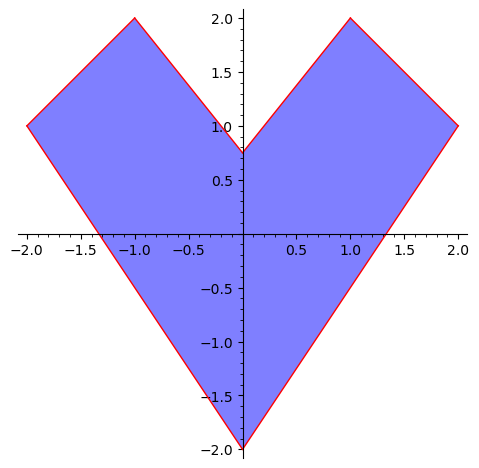

In [12]:
# Check that we parameterize the polygon.
plt2 = plt
for i in range(nv):
    plt2 = plt2 + parametric_plot(segments[i], (t, times[i], times[i+1]), color='red')
plt2

In [13]:
# We implement the pairing with the boundary curve (gamma in the problem statement)
# We use numerical integration which is faster than symbolic.
def pair_with_polygon(f):
    total = 0
    xf,yf = f
    for i in range(nv):
        xs,ys = segments[i]
        integrand(t) = xs*xf + ys*yf
        total += numerical_integral(integrand, times[i], times[i+1])[0]
    return total


In [14]:
cv = vector([pair_with_polygon(f)/RDF(norms_squared[i])
             for i,f in enumerate(basis_functions.rows())])
cv

(-3.003857199159988e-16, 0.47222222222222227, 1.0893287623637773, 0.3964832448304559, 0.3905519390688444, -1.0730326337158667, 0.40119554797765467, 0.3366430363380172, 0.8249359747777627, -0.9831204116016051, -0.13162007846365983, -0.22797266319525983, 0.26324015692731817, -0.15198177546350658, -0.04182045478913099, -0.237175584933742, -0.07730253197269182, 0.01363052206386392, 0.026765091065044214, -0.15179237435759507, 0.04947362046252209, 0.008723534120872645, 0.032905019615915264, -0.05699316579881467, -0.06581003923182925, -0.03799544386587776)

In [15]:
# Version that does not use the norm_squared:
cv = vector([pair_with_polygon(f)/RDF(2*pi) if i < 2 else pair_with_polygon(f)/RDF(pi)
             for i,f in enumerate(basis_functions.rows())])
cv

(-3.003857199159988e-16, 0.47222222222222227, 1.0893287623637773, 0.3964832448304559, 0.3905519390688444, -1.0730326337158667, 0.40119554797765467, 0.3366430363380172, 0.8249359747777627, -0.9831204116016051, -0.13162007846365983, -0.22797266319525983, 0.26324015692731817, -0.15198177546350658, -0.04182045478913099, -0.237175584933742, -0.07730253197269182, 0.01363052206386392, 0.026765091065044214, -0.15179237435759507, 0.04947362046252209, 0.008723534120872645, 0.032905019615915264, -0.05699316579881467, -0.06581003923182925, -0.03799544386587776)

In [16]:
timeit('''cv = vector([pair_with_polygon(f)/RDF(2*pi) if i < 2 else pair_with_polygon(f)/RDF(pi)
             for i,f in enumerate(basis_functions.rows())])''')

5 loops, best of 3: 96.8 ms per loop

In [17]:
approx(t) = cv*basis_functions

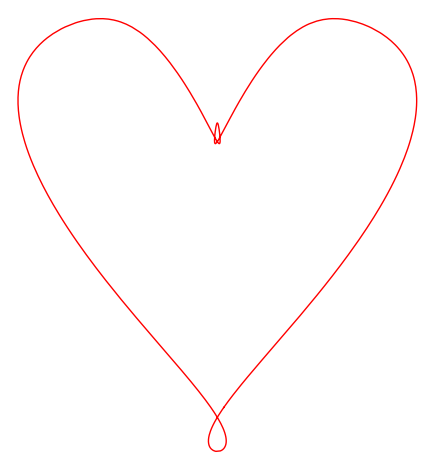

In [18]:
plt_approx = parametric_plot(approx(t), (t, 0, 2*pi), color='red', axes=False)
plt_approx

In [19]:
def approximate_polygon(frequency_bound, vertices, times = 'count'):
    r'''Given a frequency bound, we approximate the polygonal path joining 
    the vertices by a finite Fourier series defined over the interval [0, 2*pi].

    We require that the first vertex and the last vertex are equal.

    `times` should either be:
    * A list of times at which the path should visit each vertex. The first item 
      of the list should be zero, but we do not require that the last be 2*pi, 
      because we will rescale the times.
    * The string 'count' in which case, times is the the list [0, 1, 2, ..., n-1] 
      where `n=len(vertices)`.
    * The string 'length' in which case the time between vertices is the Euclidean
      distance between the vertices.
    '''
    def basis(frequency_bound):
        var('t')
        basis = [(1, 0), (0, 1)]
        for i in range(1, frequency_bound+1):
            basis.append((sin(i*t), 0))
            basis.append((cos(i*t), 0))
            basis.append((0, sin(i*t)))
            basis.append((0, cos(i*t)))
        return basis
    basis_functions = matrix(SR, basis(frequency_bound))

    # Record the number of segments
    nv = len(vertices)-1
    # Ensure vertices are vectors:
    vertices = [vector(v) for v in vertices]

    if times == 'count':
        times = list(range(len(vertices)))
    elif times == 'length':
        traveled = RDF(0)
        times = [traveled]
        for i in range(nv):
            traveled += (vertices[i+1]-vertices[i]).norm()
            times.append(traveled)
    assert len(times) == len(vertices), 'times should have the same length as vertices.'
    #rescale times to be in the interval [0, 2*pi]
    times = [t*2*pi/times[-1] for t in times]

    segments = []
    for i in range(nv):
        a = times[i]
        b = times[i+1]
        seg(t) = (1/(b-a) * ((b-t)*vertices[i]+(t-a)*vertices[i+1])).simplify()
        segments.append(seg)

    # We implement the pairing with the boundary curve (gamma in the problem statement)
    # We use numerical integration which is faster than symbolic.
    def pair_with_polygon(f):
        total = 0
        xf,yf = f
        for i in range(nv):
            xs,ys = segments[i]
            integrand(t) = xs*xf + ys*yf
            total += numerical_integral(integrand, times[i], times[i+1])[0]
        return total

    # Version that does not use the norm_squared:
    cv = vector([pair_with_polygon(f)/RDF(2*pi) if i < 2 else pair_with_polygon(f)/RDF(pi)
                 for i,f in enumerate(basis_functions.rows())])
    approx(t) = cv*basis_functions
    return approx

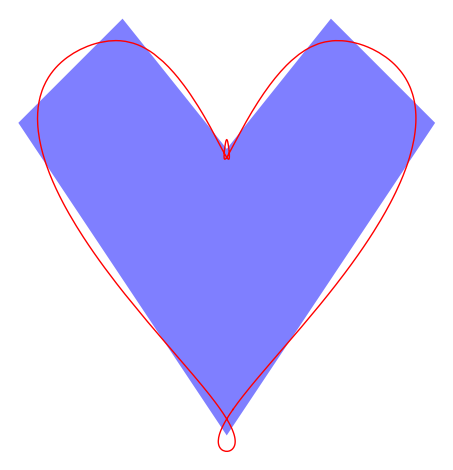

In [20]:
vertices = [(0, -2), (2, 1), (1, 2), (0, 3/4), (0, 3/4), (-1, 2), (-2, 1),(0, -2),(0, -2)]
times =    [      0,      1,      2,        3,        5,       6,       7,      8,      9]
plt1 = polygon2d(vertices, alpha=0.5, axes=False)
approx = approximate_polygon(6, vertices, times)
plt2 = parametric_plot(approx(t), (t, 0, 2*pi), color='red', axes=False)
plt1 + plt2

In [22]:
@interact
def approx_pat(frequency_bound = input_box(0)):
    vertices = [(0, 0), (0, 2), (1, 2), (1, 1), (0, 1), (0, 0), 
                (3/2, 0), (2, 2), (5/2, 0), (9/4, 1), (7/4, 1), (9/4, 1), (5/2, 0), 
                (4, 0), (4, 2), (3, 2), (5, 2), (4, 2), (4, 0), (9/2, -1/2),
                (-1/2, -1/2), (0,0),
               ]
    plt1 = polygon2d(vertices, alpha=0.5, axes=False, thickness=2)
    approx = approximate_polygon(frequency_bound, vertices, 'count')
    plt2 = parametric_plot(approx(t), (t, 0, 2*pi), color='red', axes=False)
    show(plt1 + plt2)

Interactive function <function approx_pat at 0x7f9fcd775300> with 1 widget
  frequency_bound: EvalText(value='0', description='frequency_bound', layout=Layout(max_width='81em'))

## Problem 2:

Write a function which given a `degree_bound` returns an orthonormal basis for the space of polynomials of degree $\leq n$ on the triangle $T$ with vertices $(0,0)$, $(1,0)$ and $(0,2)$ with respect to the inner product:
$$\langle f, g \rangle = \iint_T f(x,y) g(x,y)~dA.$$
Use the Graham-Schmidt Orthogonalization process!

In [23]:
var('x y')

(x, y)

In [24]:
def simple_basis(degree_bound):
    basis = [1]
    for d in range(1, degree_bound+1):
        basis.append(SR(x^d))
        basis.append(SR(y^d))
    return basis

In [25]:
simple_basis(3)

[1, x, y, x^2, y^2, x^3, y^3]

In [26]:
def inner_product(f, g):
    integrand(x,y) = f*g
    return integrand.integral(y, 0, 2-2*x).integral(x, 0, 1)

In [27]:
def projection(orthonormal_basis, f):
    total = 0
    for b in orthonormal_basis:
        total += inner_product(f, b)*b
    return total

In [28]:
def orthonormal_basis(degree_bound):
    original_basis = simple_basis(degree_bound)
    basis = [original_basis[0] / sqrt(inner_product(original_basis[0], original_basis[0])), ]
    
    for i in range(1, len(original_basis)):
        f = original_basis[i]
        p = projection(basis, f)
        ff = f - p
        basis.append(ff/sqrt(inner_product(ff,ff)).full_simplify())
    return basis

In [29]:
basis = orthonormal_basis(3)
basis

[1,
 sqrt(2)*(3*x - 1),
 sqrt(6)*(x + y - 1),
 sqrt(3)*(10*x^2 - 8*x + 1),
 -1/8*sqrt(3)*sqrt(2)*(20*x^2 - 15*y^2 - 16*x + 24*y - 4),
 70*x^3 - 90*x^2 + 30*x - 2,
 1/3*sqrt(5)*sqrt(3)*(14*x^3 + 7*y^3 - 18*x^2 - 18*y^2 + 6*x + 12*y - 2)]

In [30]:
# Check the basis is orthogonal
for i in range(len(basis)):
    bi = basis[i]
    for j in range(i+1, len(basis)):
        bj = basis[j]
        if inner_product(bi, bj) != 0:
            print(i, j)

In [31]:
# Check that all elements have norm 1
for i in range(len(basis)):
    bi = basis[i]
    if not inner_product(bi, bi) == 1:
        print(i)

We remark that SageMath has several [important families of orthonormal polynomials built in](https://doc.sagemath.org/html/en/reference/functions/sage/functions/orthogonal_polys.html). But, if you want something non-standard, you can do it yourself using Graham-Schmidt.